In [292]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime as dt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = 'DataProvided'
file_list = os.listdir(path)
file_list

['Central Regional Fall 2021 Data Schema.docx',
 'Central Regional Fall 2021 Problem Statement.docx',
 'death_rates_smoking_age.csv',
 'sales_per_day.csv',
 'stop_smoking.csv',
 'tobacco_production.csv',
 'tobacco_production_footnotes.txt',
 'tobacco_use_us.csv',
 'tobacco_use_ww.csv',
 'us_chronic_resp_disease.csv']

In [3]:
death_df_path = os.path.join(path,'death_rates_smoking_age.csv')
entity_code_dict = pd.read_csv(os.path.join(path,'death_rates_smoking_age.csv'), usecols = ['Entity','Code'],index_col = 'Entity')['Code'].to_dict()

In [193]:
class DeathData:
    def __init__(self, death_df, drop_col = 'Code'):
        if isinstance(death_df,str):
            death_df = pd.read_csv(death_df)
        country_filter = death_df['Code'].notnull()
        death_df.drop(drop_col, axis = 1, inplace = True)
        self._death_df_country = Dataframe(death_df.loc[country_filter], time_col = 'Year', key_col = 'Entity')
        self._death_df_non_country = Dataframe(death_df.loc[-country_filter], time_col = 'Year', key_col = 'Entity')
    @property
    def country(self):
        return self._death_df_country
    @property
    def not_country(self):
        return self._death_df_non_country
class Dataframe:
    def __init__(self, data, time_col, key_col):
        self.data = data
        self.time_col = time_col
        self.key_col = key_col
    def pivot_ts(self, value, aggfunc = 'sum'):
        return self.data.pivot_table(index = self.time_col, columns = self.key_col, values = value, aggfunc = aggfunc)
    def pivot_key(self, key, value_columns = None, aggfunc = 'sum'):
        if not value_columns: 
            value_columns = self.columns
        return self.data\
                    .loc[self.data[self.key_col]==key]\
                    .groupby(self.time_col).agg({col:aggfunc for col in value_columns})
    @property
    def columns(self):
        return [x for x in self.data.columns if x not in [self.time_col, self.key_col]]
    @property
    def key(self):
        return self.data[self.key_col].unique()
    @property
    def ts(self):
        return self.data[self.time_col].unique()
    def getSummary(self, based_on = 'key'):
        if based_on == 'key':
            return self.data.groupby(self.key_col)[self.time_col].describe()
        if based_on == 'ts':
            return self.data.groupby(self.time_col)[self.key_col].count().to_frame('count')
        
def getRollingCoef(df, y_col, x_cols, rolling_window = 5):
    length = len(df)
    OLS_result_dict = {}
    for i in range(rolling_window-1,length):
        window_df = df.iloc[i-4:i+1]
        params = sm.OLS(window_df[y_col], window_df[x_cols]).fit().params
        OLS_result_dict[df.index[i]] = params

    coef_df = pd.DataFrame(OLS_result_dict).T
    return coef_df

In [63]:
death_df = DeathData(death_df_path, drop_col = 'Code')

In [64]:
death_df.country.getSummary(based_on = 'ts')['count'].describe()

count     28.0
mean     196.0
std        0.0
min      196.0
25%      196.0
50%      196.0
75%      196.0
max      196.0
Name: count, dtype: float64

In [65]:
death_df.country.getSummary(based_on = 'key')['count'].describe()

count    196.0
mean      28.0
std        0.0
min       28.0
25%       28.0
50%       28.0
75%       28.0
max       28.0
Name: count, dtype: float64

In [196]:
df_by_country_dict[key].columns

Index(['All_ages', 'Under_5', '5_14', '50_69', '15_49', '70_plus'], dtype='object')

In [323]:
ts_list = death_df.country.ts
ts_list

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017], dtype=int64)

In [222]:
df_by_country_dict = {key:death_df.country.pivot_key(key) for key in death_df.country.key}
pct_change_df_by_country_dict = {key:value.pct_change().iloc[1:]*100 for key,value in df_by_country_dict.items()}

df_by_not_country_dict = {key:death_df.not_country.pivot_key(key) for key in death_df.not_country.key}
pct_change_df_by_not_country_dict = {key:value.pct_change().iloc[1:]*100 for key,value in df_by_not_country_dict.items()}

  0%|          | 0/35 [00:00<?, ?it/s]

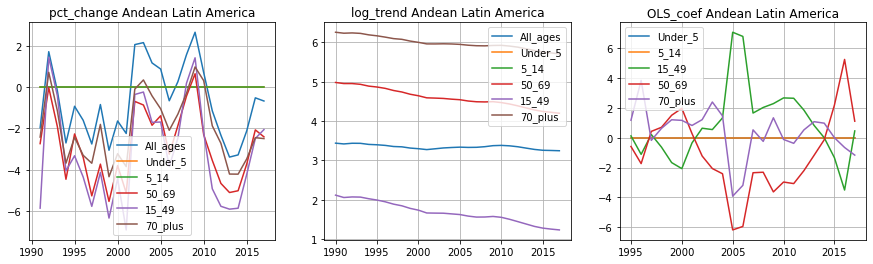

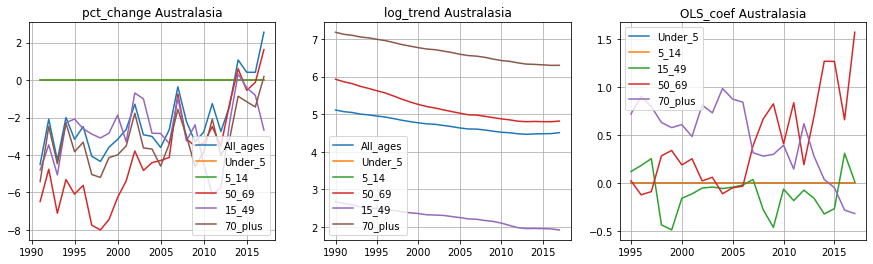

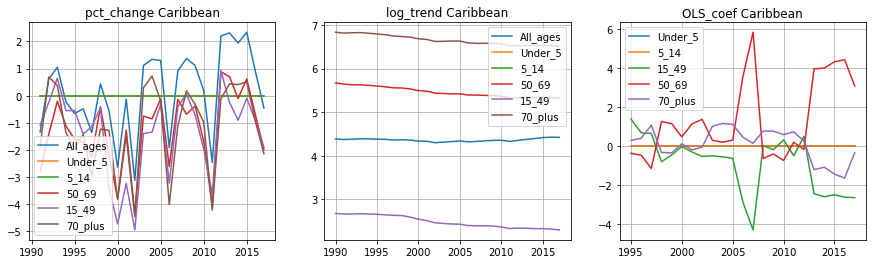

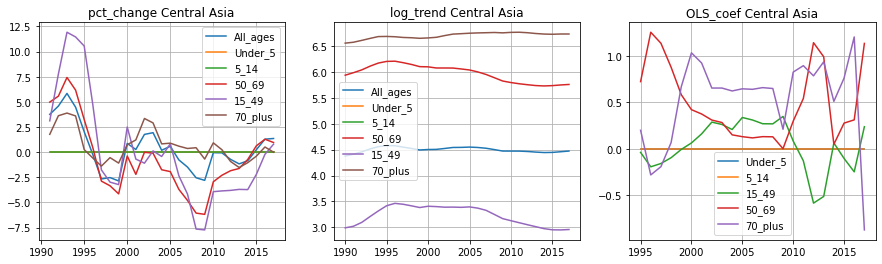

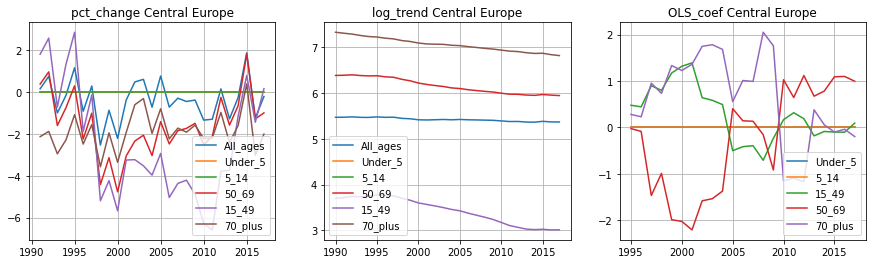

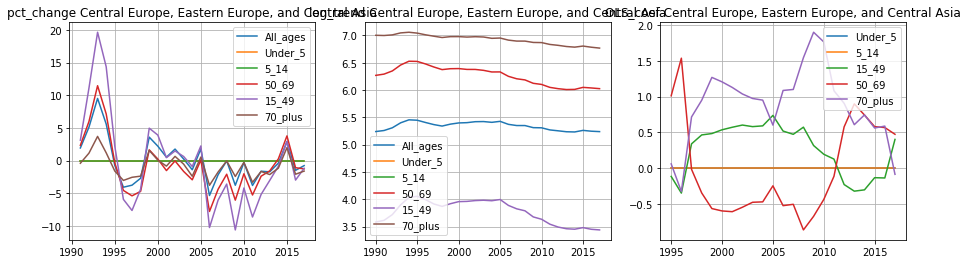

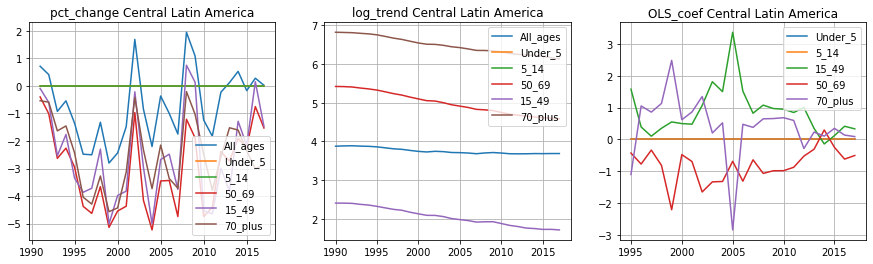

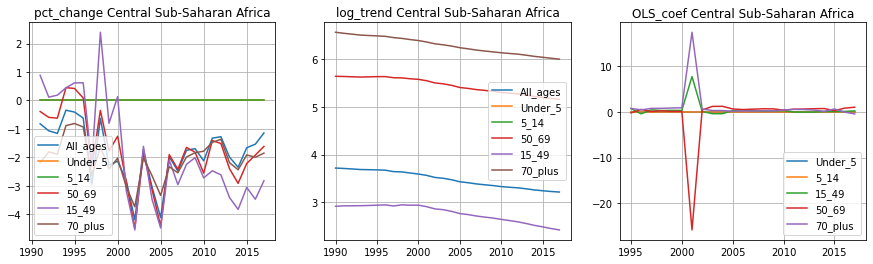

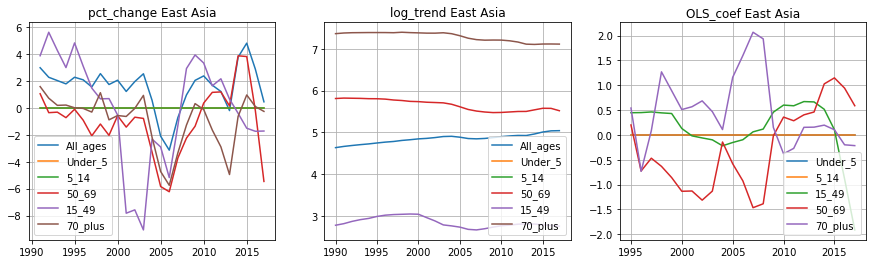

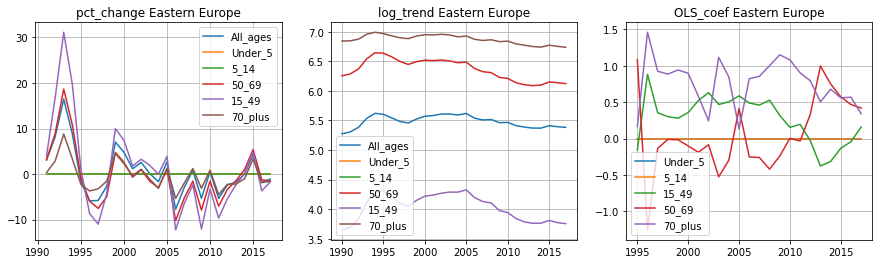

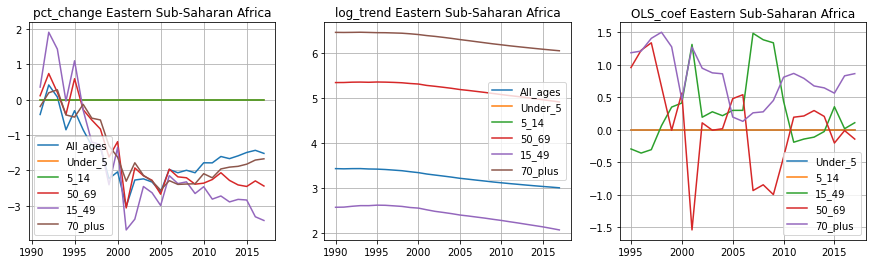

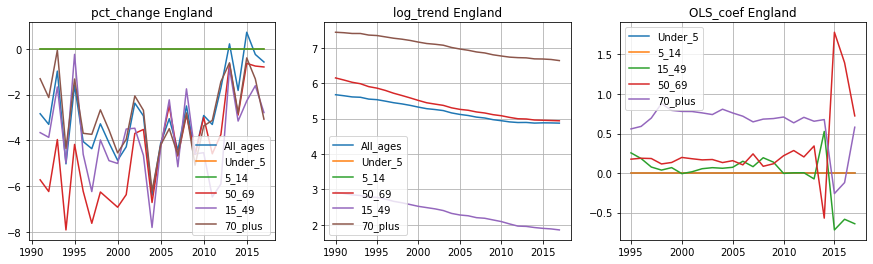

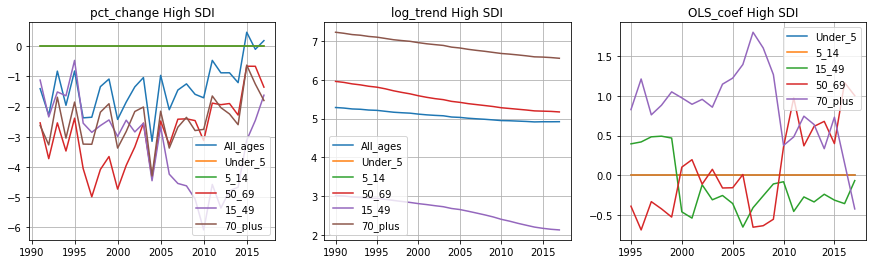

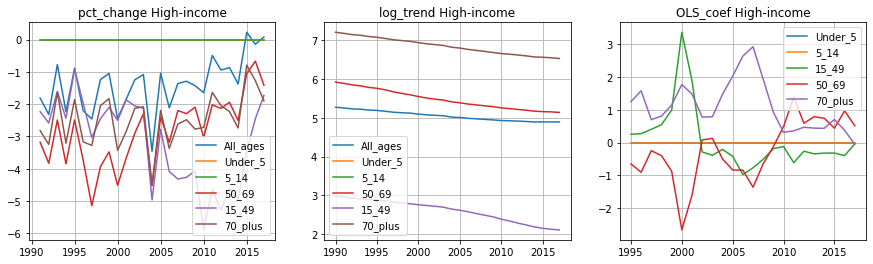

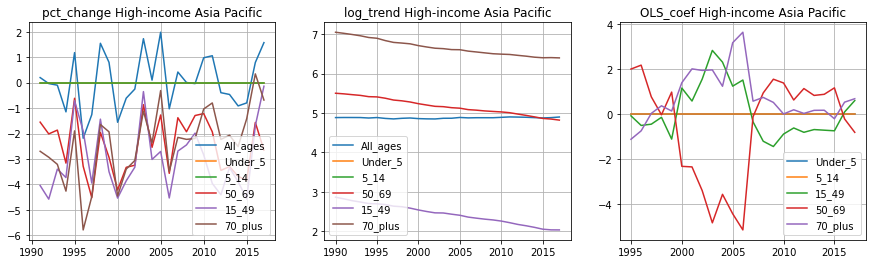

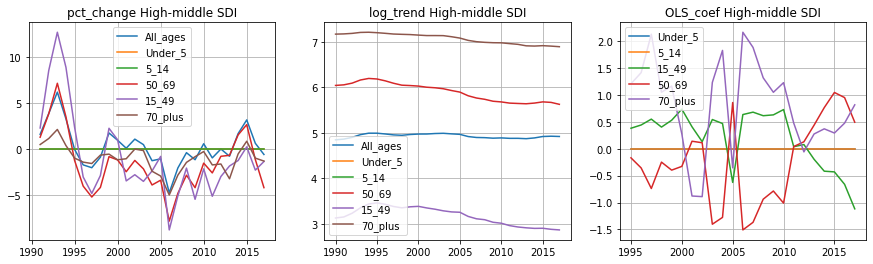

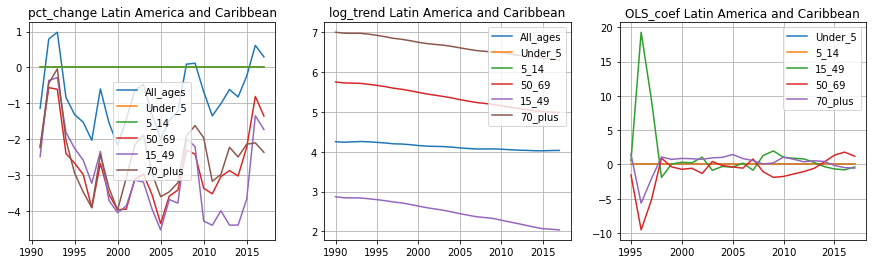

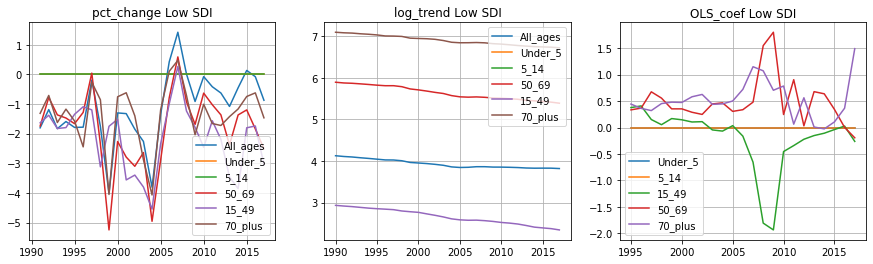

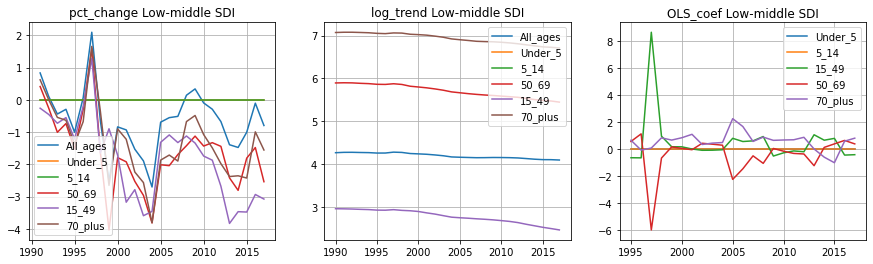

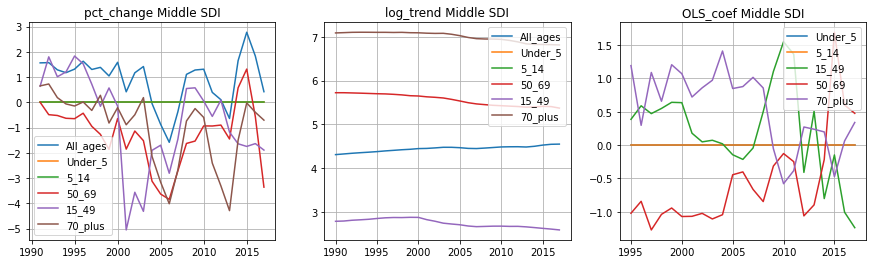

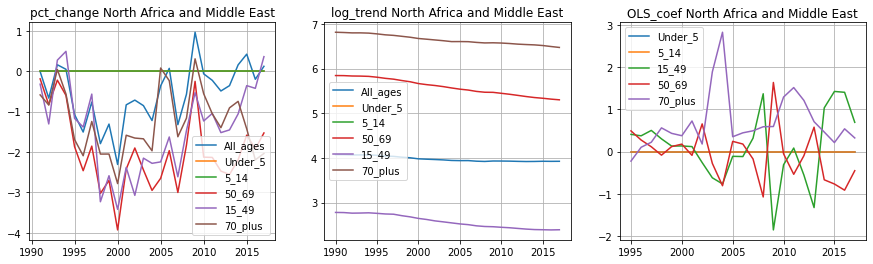

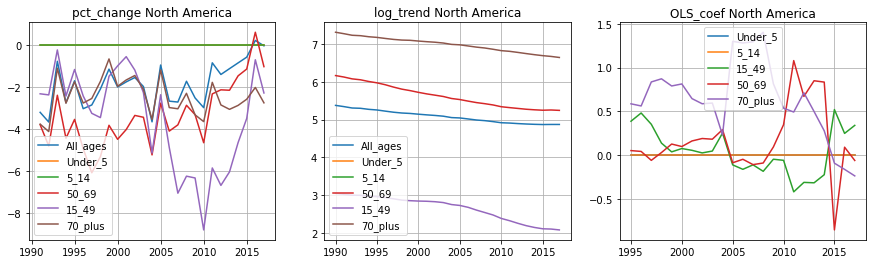

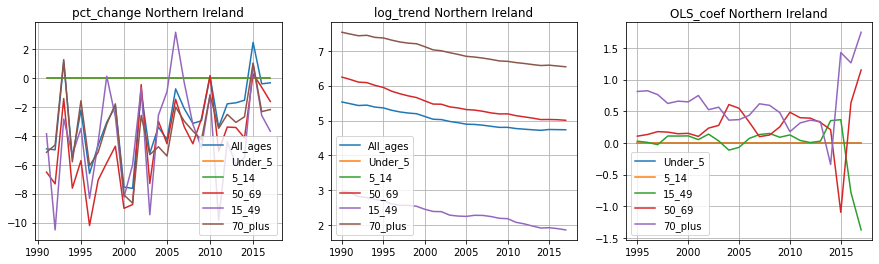

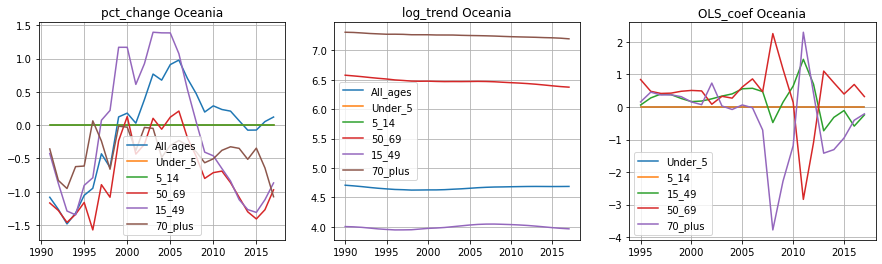

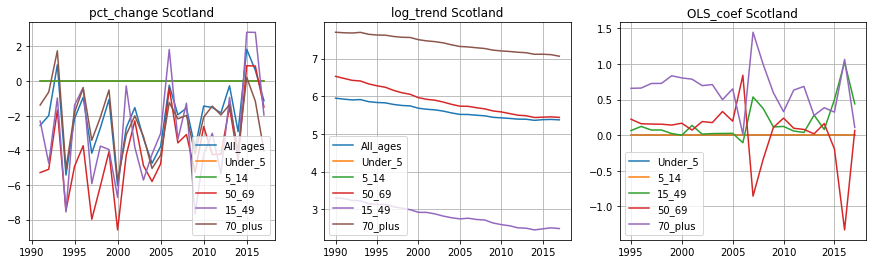

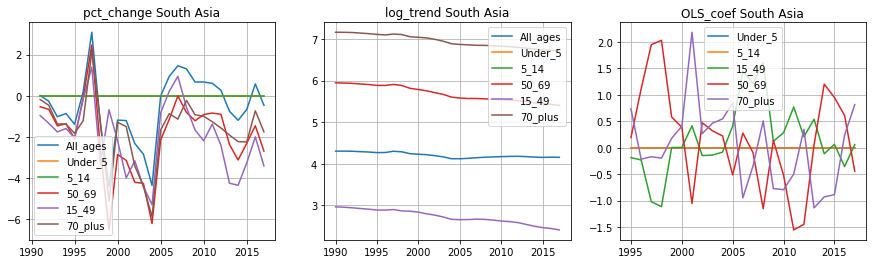

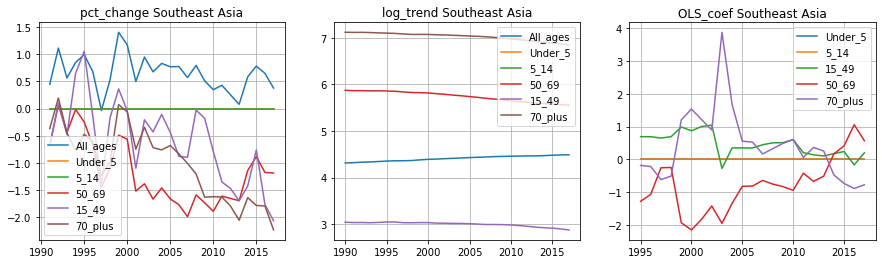

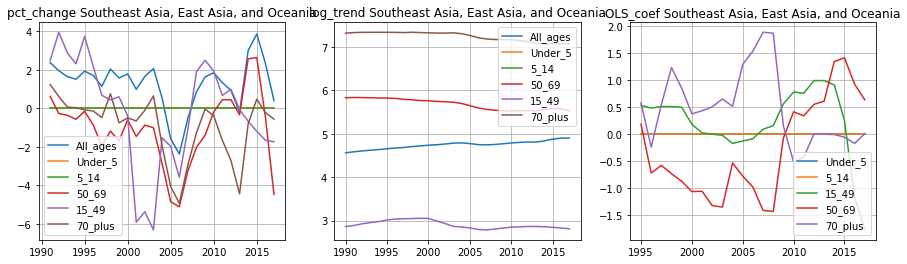

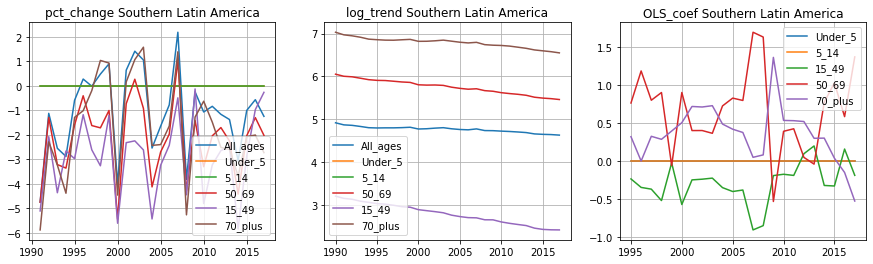

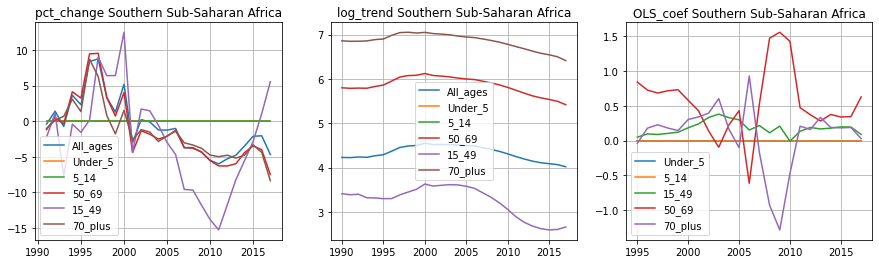

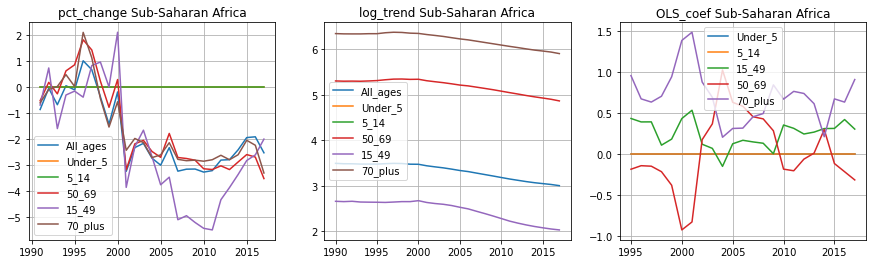

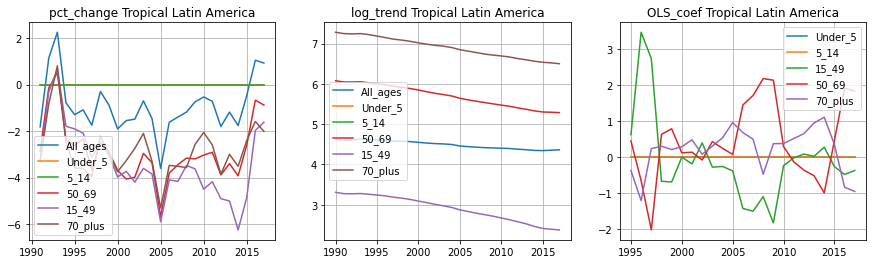

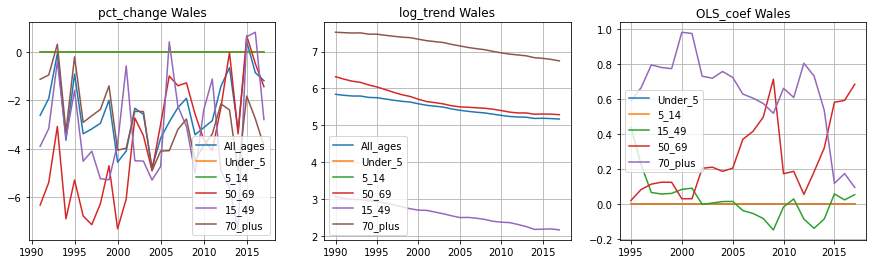

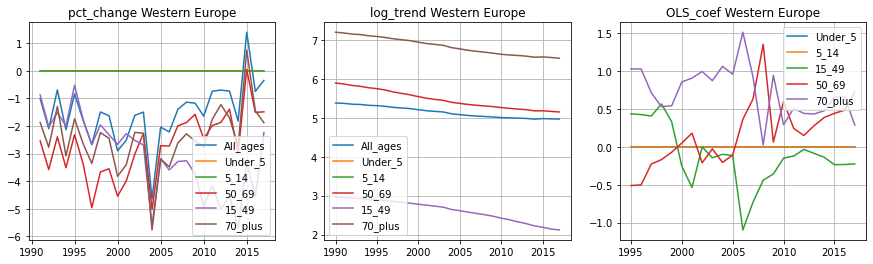

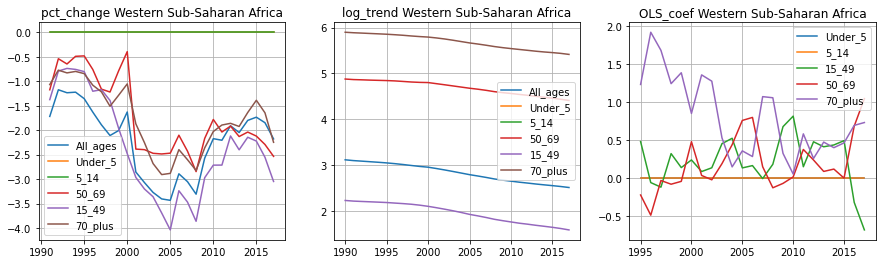

In [223]:
pct_df_dict = pct_change_df_by_not_country_dict
trend_dict = df_by_not_country_dict
key_list = death_df.not_country.key

for key in tqdm(key_list):
    pct_df = pct_df_dict[key].fillna(0)
    log_trend_df = np.log(trend_dict[key])
    rolling_coef = getRollingCoef(pct_df,'All_ages',['Under_5', '5_14', '15_49','50_69', '70_plus'], rolling_window = 5)
    data_list = [("pct_change", pct_df), ("log_trend", log_trend_df), ("OLS_coef", rolling_coef)]

    plt.figure(figsize = [15,4])
    length = len(data_list)
    for i,data in enumerate(data_list):
        plt.subplot(1,length,i+1)
        data_name,data_value = data
        plt.title("%s %s"%(data_name,key))
        plt.plot(data_value)
        plt.legend(data_value.columns)
        plt.grid(True)
    plt.show()

  0%|          | 0/196 [00:00<?, ?it/s]

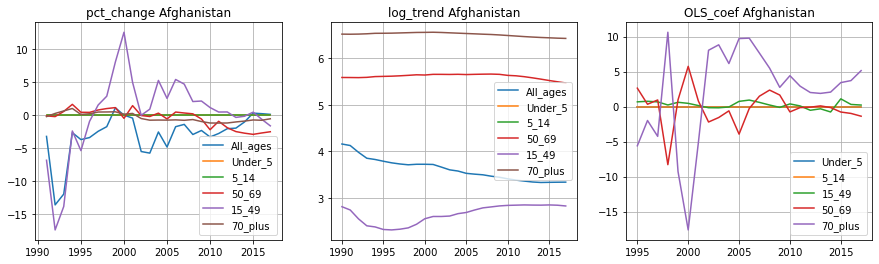

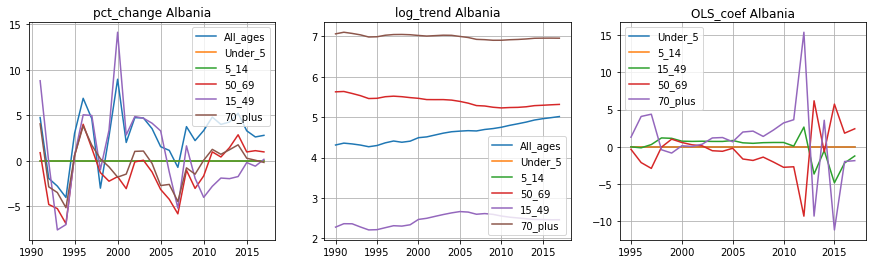

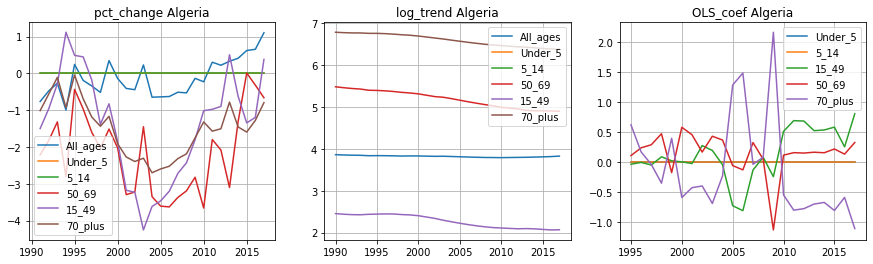

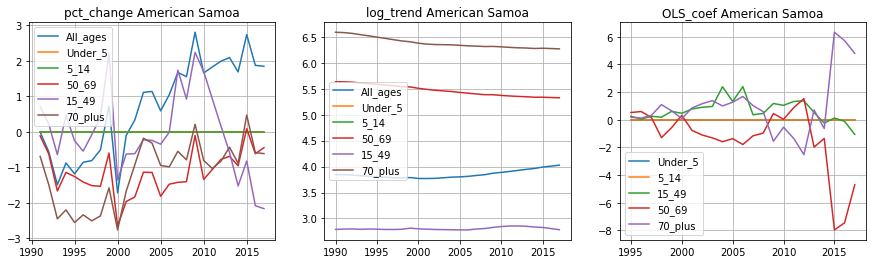

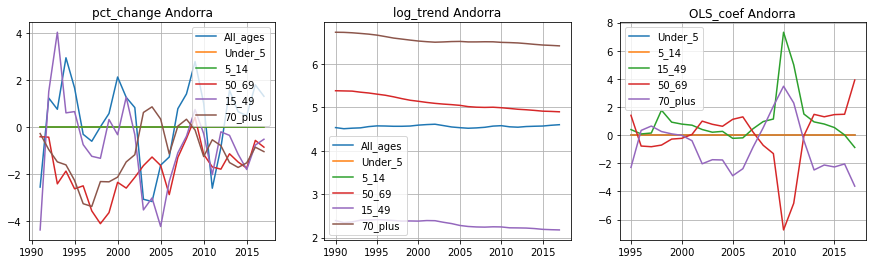

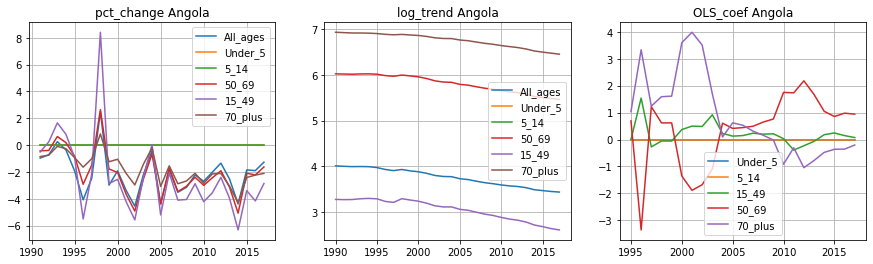

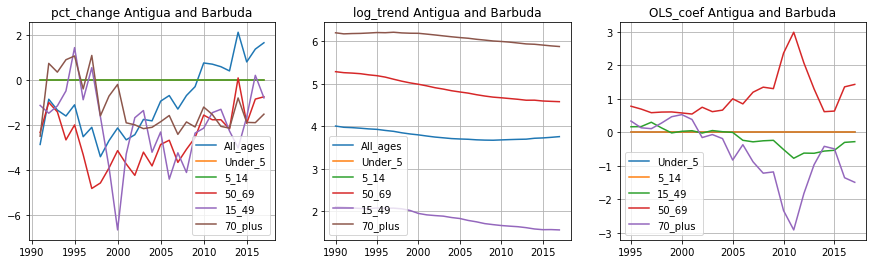

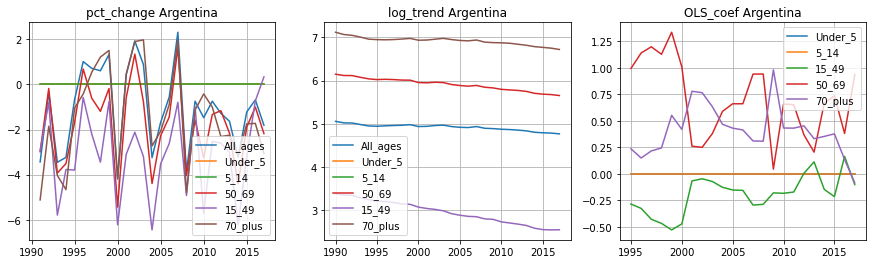

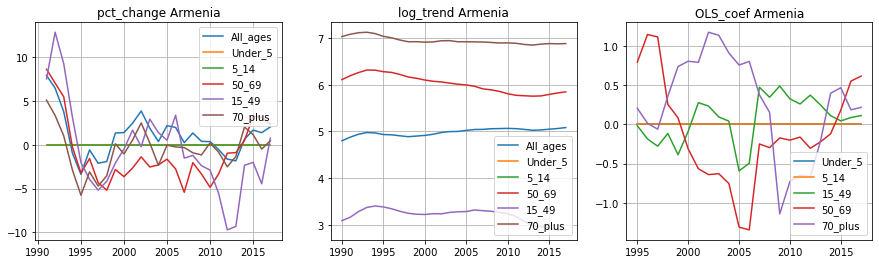

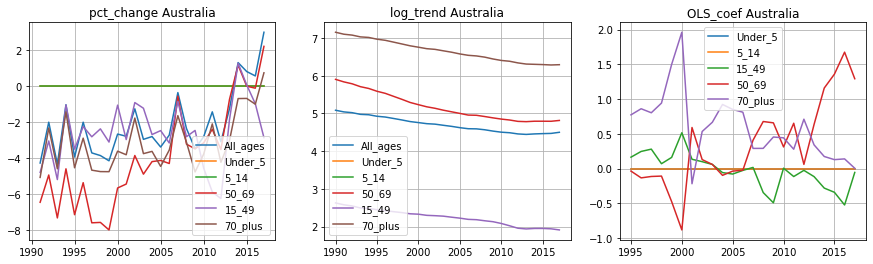

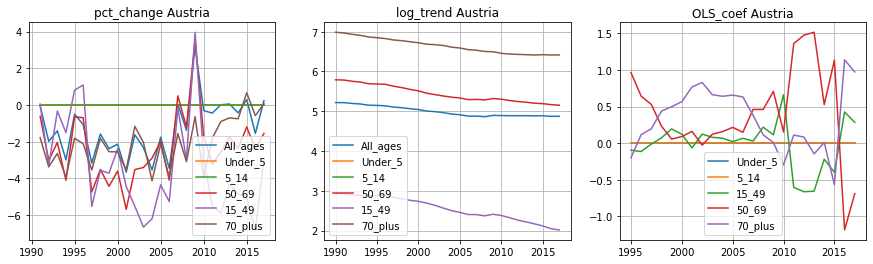

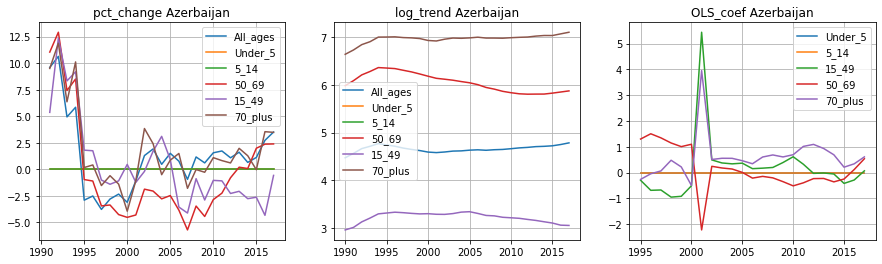

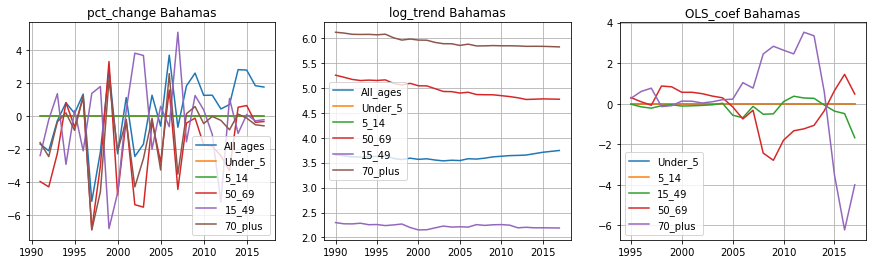

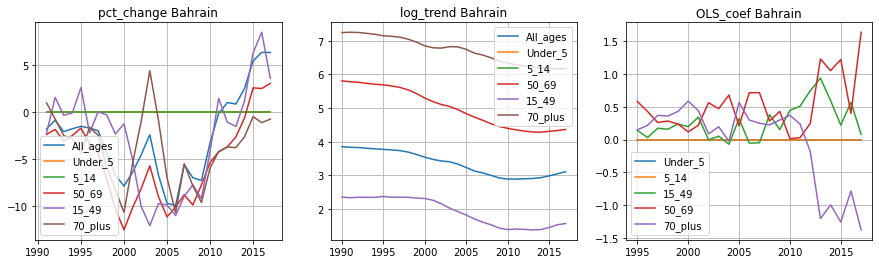

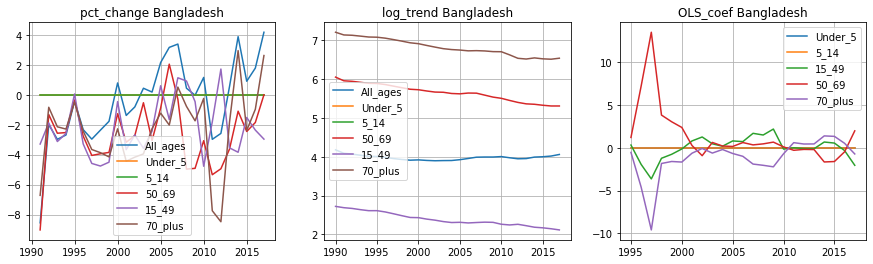

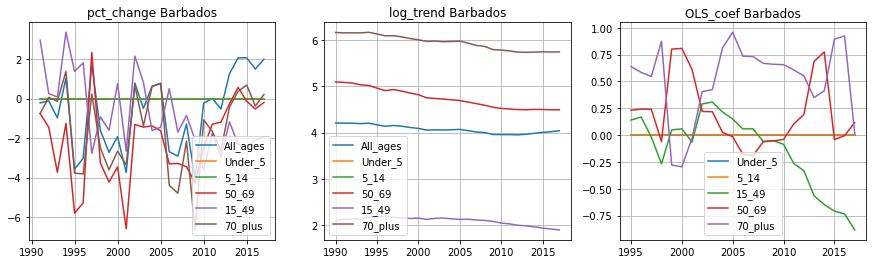

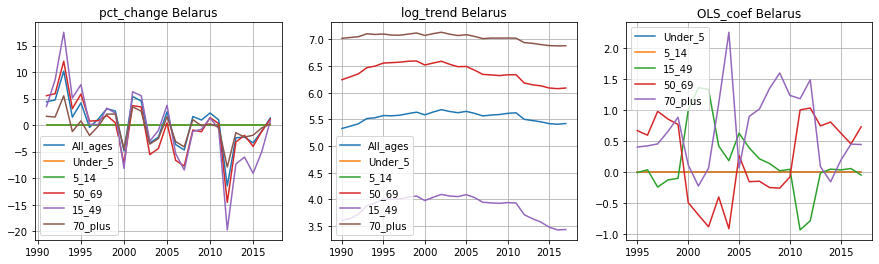

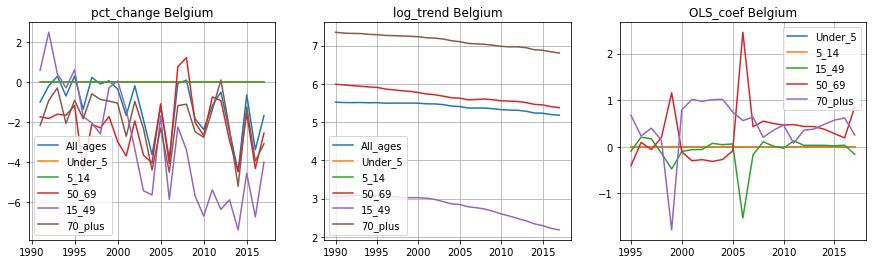

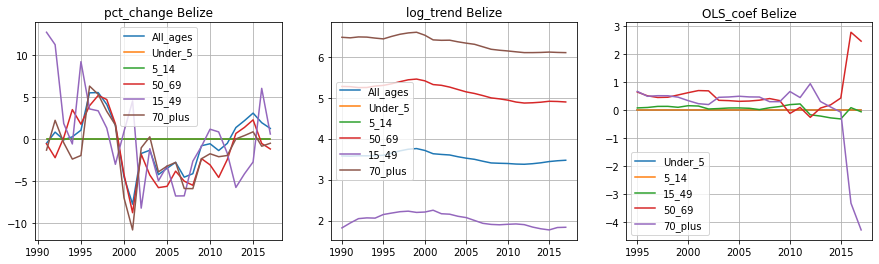

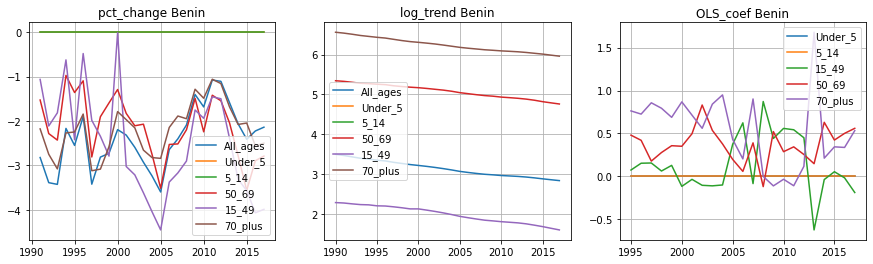

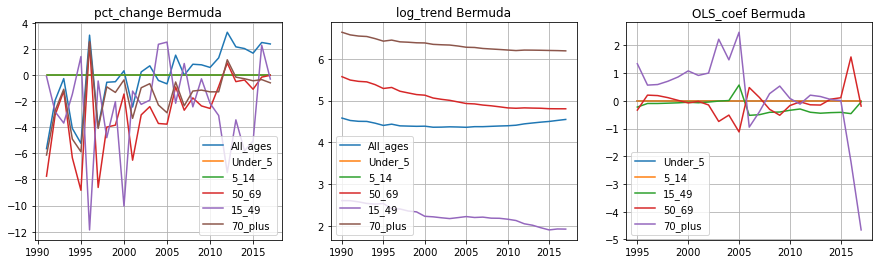

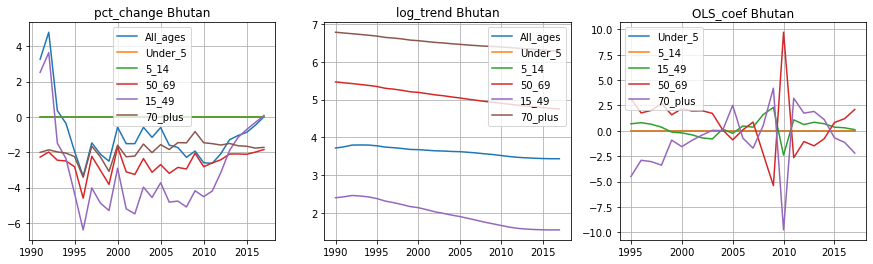

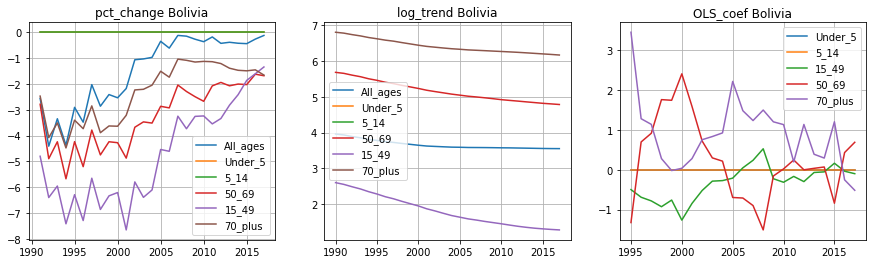

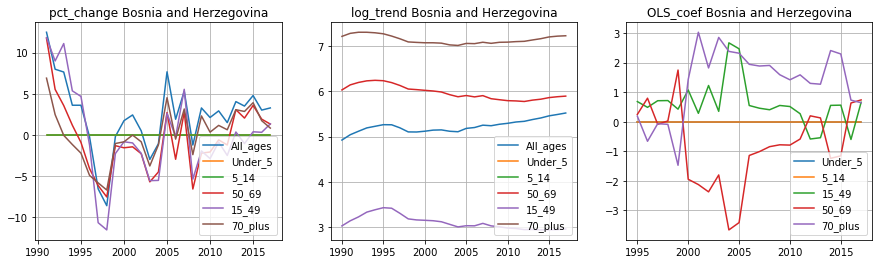

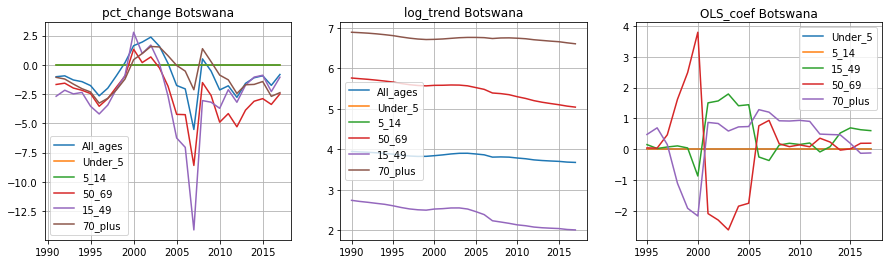

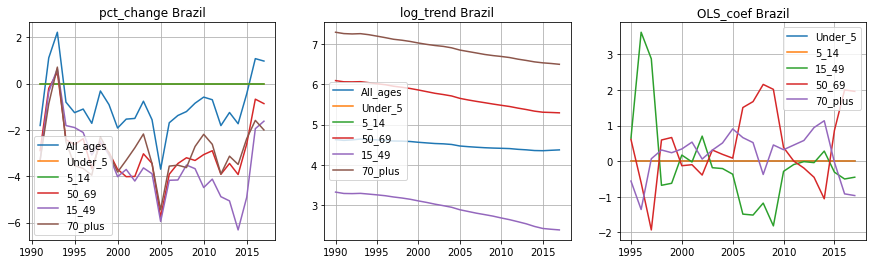

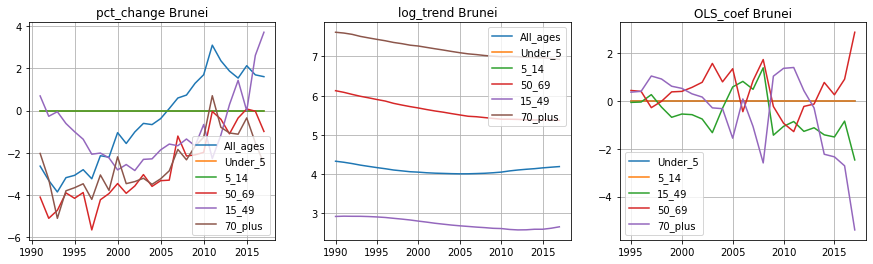

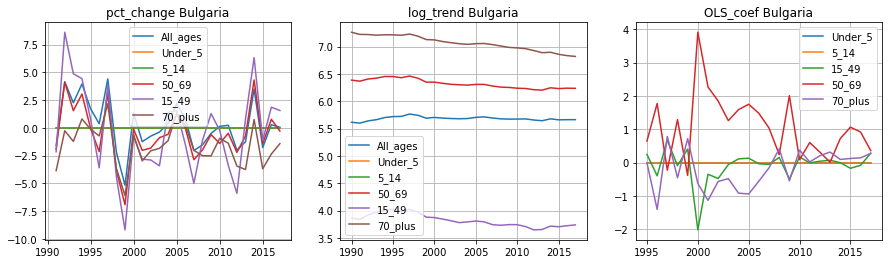

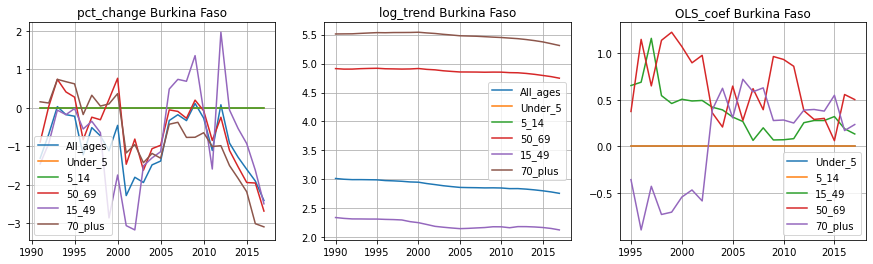

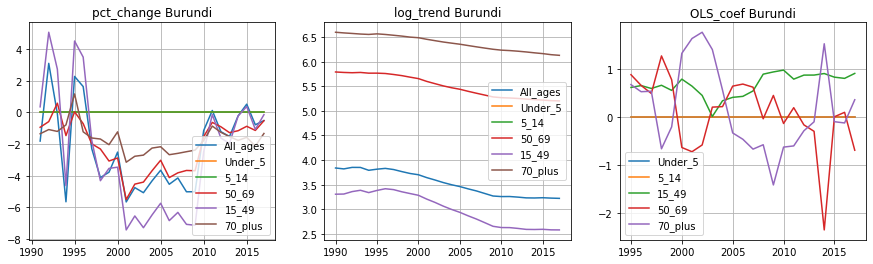

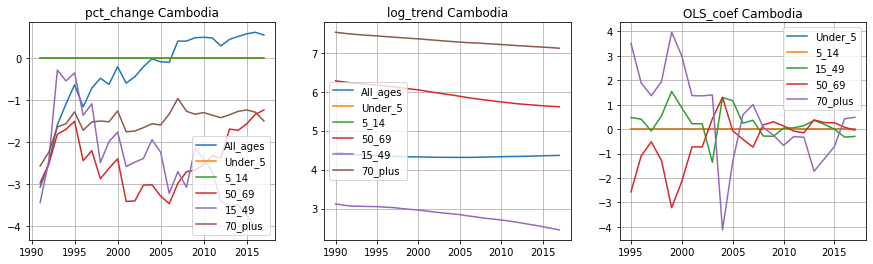

KeyboardInterrupt: 

In [217]:
pct_df_dict = pct_change_df_by_country_dict
trend_dict = df_by_country_dict

for key in tqdm(key_list):
    pct_df = pct_df_dict[key].fillna(0)
    log_trend_df = np.log(trend_dict[key])
    rolling_coef = getRollingCoef(pct_df,'All_ages',['Under_5', '5_14', '15_49','50_69', '70_plus'], rolling_window = 5)
    data_list = [("pct_change", pct_df), ("log_trend", log_trend_df), ("OLS_coef", rolling_coef)]

    plt.figure(figsize = [15,4])
    length = len(data_list)
    for i,data in enumerate(data_list):
        plt.subplot(1,length,i+1)
        data_name,data_value = data
        plt.title("%s %s"%(data_name,key))
        plt.plot(data_value)
        plt.legend(data_value.columns)
        plt.grid(True)
    plt.show()

<AxesSubplot:>

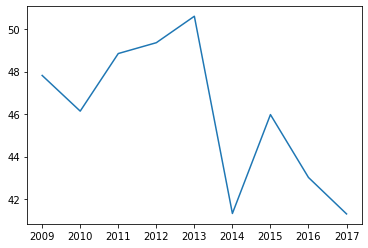

In [357]:
from itertools import combinations
col = 'All_ages'
length = 10
country_list = list(pct_change_df_by_country_dict.keys())

coint_test = {}
for x,y in tqdm(combinations(country_list, 2)):
    ts_series_a =  pct_change_df_by_country_dict[x][col]
    ts_series_b =  pct_change_df_by_country_dict[y][col]
    index_list = ts_series_a.index

    coint_test_ts = {}
    for i in range(length, len(ts_series_a)+1):
        coint_test_ts[index_list[i-1]] = sm.tsa.stattools.coint(
            ts_series_a[i-length:i], 
            ts_series_b[i-length:i]
        )
    coint_test[(x,y)] = coint_test_ts

coint_df = pd.DataFrame({"_".join(pair):{ts:pair_result[ts][1] for ts in ts_list[19:]} for pair,pair_result in coint_test.items()})
chosen_list = {country:[country_pair for country_pair in coint_df.columns if country in country_pair] for country in country_list}
coint_df_result = {country:(coint_df[result_column] <= 0.01).sum(axis = 1) for country,result_column in chosen_list.items()}
pd.DataFrame(coint_df_result).mean(axis = 1).plot()

In [377]:
model = ExponentialSmoothing(np.asarray(train['data']), trend='mul', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train['data']), trend='mul', seasonal=None, damped=True)
model._index = pd.to_datetime(train.index)

NameError: name 'train' is not defined

(-2.7032397015220395,
 0.19841564187534205,
 array([-4.84977469, -3.80737694, -3.36127041]))

In [245]:
sm.tsa.stattools.coint

In [346]:
sm.tsa.stattools.coint?